In [56]:
import json 
import os
import pandas as pd
from tqdm import tqdm
import mapbox_vector_tile
from transformers import AutoTokenizer, AutoModelForCausalLM
import copy
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import operator as op
import math

import shapely

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")

In [57]:
from shapely import LineString, Polygon
line = LineString([(0, 0), (1, 10), (0, 20)])
print(shapely.simplify(line, tolerance=0.9))

print(shapely.simplify(line, tolerance=1))

polygon_with_hole = Polygon(
    [(0, 0), (0, 10), (10, 10), (10, 0), (0, 0)],
    holes=[[(2, 2), (2, 4), (4, 4), (4, 2), (2, 2)]]
)
print(shapely.simplify(polygon_with_hole, tolerance=4, preserve_topology=True))

print(shapely.simplify(polygon_with_hole, tolerance=4, preserve_topology=False))

LINESTRING (0 0, 1 10, 0 20)
LINESTRING (0 0, 0 20)
POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0), (2 2, 2 4, 4 4, 4 2, 2 2))
POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))


In [58]:
print(shapely.simplify(polygon_with_hole, tolerance=6, preserve_topology=False))

POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))


In [59]:
json.loads(shapely.to_geojson(polygon_with_hole))["coordinates"]

[[[0.0, 0.0], [0.0, 10.0], [10.0, 10.0], [10.0, 0.0], [0.0, 0.0]],
 [[2.0, 2.0], [2.0, 4.0], [4.0, 4.0], [4.0, 2.0], [2.0, 2.0]]]

In [60]:
FILE_DIR = '../../map_generation/EDA'
ALL_VECTOR_DIR = '../../data/vector_tiles'
files = ['file1.json', 'file2.json', 'file3.json']

def mvt2json(path):
    with open(path, mode="rb") as mvt_file:
        contents = mvt_file.read()
        return  mapbox_vector_tile.decode(contents)

In [104]:
poly = [[[[3102, 4129], [3070, 4057], [2977, 4097], [2991, 4129], [3102, 4129]]], [[[3119, 4129], [3116, 4124], [3104, 4129], [3119, 4129]]]]
poly

[[[[3102, 4129], [3070, 4057], [2977, 4097], [2991, 4129], [3102, 4129]]],
 [[[3119, 4129], [3116, 4124], [3104, 4129], [3119, 4129]]]]

In [121]:
newpoly = []
for pol in poly:
    newpoly.append((pol[0], []))
ob = shapely.MultiPolygon(newpoly)

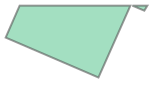

In [122]:
ob

In [118]:
ob = shapely.MultiPolygon([
    (
    [[0.0, 0.0], [0.0, 1.0], [1.0, 1.0], [1.0, 0.0]],
    []
    ),
    (
    [[2.0, 2.0], [2.0, 3.0], [3.0, 3.0], [3.0, 2.0]],
    []
    )
    ])

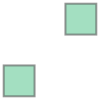

In [119]:
ob

In [106]:
shapely.MultiPolygon(newpoly)

TypeError: 'int' object is not iterable

In [97]:
def get_bbox_diameter(shape):
    bbox = shape.bounds
    return math.sqrt((bbox[3]-bbox[1])**2 + (bbox[2]-bbox[0])**2)

def json2shapely(geometry, geo_type):
    try:
        if geo_type == 'Point':
            return shapely.Point(geometry['coordinates'])
        elif geo_type == 'LineString':
            return shapely.LineString(geometry['coordinates'])
        elif geo_type == 'MultiLineString':
            return shapely.MultiLineString(geometry['coordinates'])
        elif geo_type == 'Polygon':
            return shapely.Polygon(geometry['coordinates'][0])
        elif geo_type == 'MultiPolygon':
            polygons = geometry['coordinates']
            newpoly = []
            for polygon in polygons:
                newpoly.append((polygon[0], []))
            return shapely.MultiPolygon(newpoly)
    except:
        print(geometry['coordinates'])
        raise ValueError('A very specific bad thing happened.')
    
def simplify_geo(geometry, geotype, perc):
    if geotype != 'Point':
        shape = json2shapely(geometry, geotype)
        tolerance = get_bbox_diameter(shape) * perc
        newshape = shapely.simplify(shape, tolerance=tolerance, preserve_topology=False)
        geometry['coordinates'] = json.loads(shapely.to_geojson(newshape))["coordinates"]
        return shape, newshape
    
def simplify(layer, perc):
    for feature in layer['features']:
        geometry = feature['geometry']
        geo_type = geometry['type']
        simplify_geo(geometry, geo_type, perc)
    return layer

In [81]:
berlin = pd.read_pickle('../../data/vector_tiles/Berlin, Germany.pkl')
path = os.path.join("../..", berlin.iloc[0]['tile'])
tile = mvt2json(path)
tile.keys()

geojson = json.dumps(tile['road']['features'][0])
shape = shapely.from_geojson(geojson)

In [82]:
feature = tile['road']['features'][0]
geometry = feature['geometry']
geotype = geometry['type']

In [83]:
old, new = simplify_geo(geometry, geotype, 0.25)
print(shapely.get_num_coordinates(old))
print(shapely.get_num_coordinates(new))

6
2


In [98]:
def testShapeComplexityImpact(tiles_df, layer_name, perc):

    tiles = {
        'complex': [],
        'simple': [],
        'perc difference': []
    }

    for idx, tile in tqdm(tiles_df.iterrows(), total=tiles_df.shape[0]):
        path = os.path.join("../..", tile['tile'])
        tile = mvt2json(path)
        if layer_name not in tile.keys():
            continue
        layer = tile[layer_name]
        layer_simple = copy.deepcopy(layer)
        complex_str = json.dumps(layer)
        simple = simplify(layer_simple, perc)
        simple_str = json.dumps(simple)
        simple_tokens = len(tokenizer.tokenize(simple_str))
        complex_tokens = len(tokenizer.tokenize(complex_str))
        tiles['simple'].append(simple_tokens)
        tiles['complex'].append(complex_tokens)
        tiles['perc difference'].append((complex_tokens - simple_tokens)/complex_tokens)
        
    return tiles
    
def visualizeSizeDiff(size):
    sorted_keys, sorted_vals = zip(*sorted(size.items(), key=op.itemgetter(1)))

    # almost verbatim from question
    boxplot = sns.boxplot(data=sorted_vals, width=.18)

    # category labels
    plt.xticks(plt.xticks()[0], sorted_keys)
    boxplot.set_yscale("log")
    boxplot.axhline(2048)
    plt.show()

In [99]:
buildings = testShapeComplexityImpact(berlin, "building", 0.5)

building_size = {
    'simple': buildings['simple'],
    'complex': buildings['complex']
}

visualizeSizeDiff(building_size)

  0%|          | 32/6786 [00:00<02:59, 37.68it/s] 


[[[[3102, 4129], [3070, 4057], [2977, 4097], [2991, 4129], [3102, 4129]]], [[[3119, 4129], [3116, 4124], [3104, 4129], [3119, 4129]]]]


ValueError: A very specific bad thing happened.